In [31]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [33]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

In [34]:
import os
import zipfile
import requests

# Define file names and paths
movies_csv_filename = "movies.csv"
ratings_csv_filename = "ratings.csv"
zip_file_url = "http://files.grouplens.org/datasets/movielens/ml-25m.zip"
zip_filename = "ml-25m.zip"
extracted_folder = "ml-25m"

# Check if the files exist in the current directory or the extracted folder
if not os.path.exists(movies_csv_filename) or not os.path.exists(ratings_csv_filename):
    if not os.path.exists(os.path.join(extracted_folder, movies_csv_filename)) or \
       not os.path.exists(os.path.join(extracted_folder, ratings_csv_filename)):

        print(f"{movies_csv_filename} or {ratings_csv_filename} not found. Attempting to download MovieLens 25M dataset.")

        # Download the zip file if it doesn't exist
        if not os.path.exists(zip_filename):
            print(f"Downloading {zip_filename}...")
            try:
                response = requests.get(zip_file_url, stream=True)
                response.raise_for_status() # Raise an exception for HTTP errors
                with open(zip_filename, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"{zip_filename} downloaded successfully.")
            except requests.exceptions.RequestException as e:
                print(f"Failed to download {zip_filename}: {e}")
                # Re-raise the error or handle it gracefully if download fails
                raise FileNotFoundError(f"Required data files could not be downloaded. Please check your internet connection or the URL: {zip_file_url}")

        else:
            print(f"{zip_filename} already exists.")

        # Extract the zip file if the extracted folder doesn't exist
        if not os.path.exists(extracted_folder):
            print(f"Extracting {zip_filename}...")
            try:
                with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                    zip_ref.extractall(".") # Extract in current directory
                print(f"Files extracted to {extracted_folder}.")
            except zipfile.BadZipFile as e:
                print(f"Failed to extract {zip_filename}: {e}. It might be corrupted.")
                raise IOError(f"Failed to extract {zip_filename}.")
        else:
            print(f"Directory {extracted_folder} already exists.")

    # After ensuring files are present, read them from the extracted folder
    data_path = extracted_folder
    movies = pd.read_csv(os.path.join(data_path, movies_csv_filename))
    ratings = pd.read_csv(os.path.join(data_path, ratings_csv_filename))
    print(f"Data loaded from {data_path}/.")

else:
    # If files already exist in the current directory, read them directly
    movies = pd.read_csv(movies_csv_filename)
    ratings = pd.read_csv(ratings_csv_filename)
    print("Data loaded from current directory.")

Data loaded from current directory.


In [35]:
movies["genres"] = movies["genres"].fillna("")
movies["clean_text"] = movies["genres"].apply(clean_text)
movies["genres"] = movies["genres"].fillna("")
movies["clean_text"] = movies["genres"].apply(clean_text)
movies["release_year"] = movies["title"].str.extract(r"\((\d{4})\)")
movies["release_year"] = pd.to_numeric(movies["release_year"], errors="coerce")


In [36]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies["clean_text"])
content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [37]:
rating_matrix = ratings.pivot_table(index="userId", columns="movieId", values="rating").fillna(0)
collab_sim = cosine_similarity(rating_matrix.T)
collab_sim_df = pd.DataFrame(collab_sim, index=rating_matrix.columns, columns=rating_matrix.columns)

In [38]:
# ------------------ Genre-based Hybrid Recommender ------------------
def recommend_by_genre(user_genre, n=10, alpha=0.5):
    global movies, ratings, content_sim, collab_sim_df, tfidf_matrix, tfidf
    import pandas as pd # Import pandas at the beginning of the function
    user_genre = user_genre.lower()
    # Ensure movies data is loaded
    if 'movies' not in globals():
        print("Loading movies data...")
        movies = pd.read_csv("movies.csv")      # movieId, title, genres
        ratings = pd.read_csv("ratings.csv")    # userId, movieId, rating

        # Fill genres and preprocess
        movies["genres"] = movies["genres"].fillna("")
        movies["clean_text"] = movies["genres"].apply(clean_text)

        # Content-based similarity
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(movies["clean_text"])
        content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        # Collaborative Filtering
        rating_matrix = ratings.pivot_table(index="userId", columns="movieId", values="rating").fillna(0)
        collab_sim = cosine_similarity(rating_matrix.T)
        collab_sim_df = pd.DataFrame(collab_sim, index=rating_matrix.columns, columns=rating_matrix.columns)

    # Check if tfidf_matrix and tfidf are defined outside the if block
    elif 'tfidf_matrix' not in globals() or 'tfidf' not in globals():
         tfidf = TfidfVectorizer()
         tfidf_matrix = tfidf.fit_transform(movies["clean_text"])


    filtered_movies = movies[movies["genres"].str.lower().str.contains(user_genre)]

    if filtered_movies.empty:
        print("No movies found for this genre. Try another.")
        return pd.DataFrame() # Return empty DataFrame if no movies found

    avg_ratings = ratings.groupby("movieId")["rating"].mean()
    # Average ratings

    filtered_movies = filtered_movies.copy()
    filtered_movies["avg_rating"] = filtered_movies["movieId"].map(avg_ratings).fillna(0)

    # Content similarity score among filtered movies
    filtered_idx = filtered_movies.index
    filtered_sim = content_sim[filtered_idx][:, filtered_idx]
    content_scores = filtered_sim.mean(axis=1)

    # Collaborative score for filtered movies
    collab_scores = []
    for mid in filtered_movies["movieId"]:
        if mid in collab_sim_df.index:
            score = collab_sim_df[mid].reindex(movies["movieId"]).fillna(0).mean()
        else:
            score = 0
        collab_scores.append(score)

    # Hybrid score = alpha * content + (1-alpha) * collaborative + avg_rating normalization
    hybrid_score = alpha * content_scores + (1-alpha) * np.array(collab_scores) + filtered_movies["avg_rating"].values / 5
    filtered_movies["hybrid_score"] = hybrid_score

    top_movies = filtered_movies.sort_values("hybrid_score", ascending=False).head(n)

    # Calculate TF-IDF score for each movie in the top recommendations
    top_movies_tfidf = tfidf_matrix[top_movies.index]
    tfidf_scores = top_movies_tfidf.sum(axis=1).A1 # Sum TF-IDF scores for each movie and convert to 1D array
    top_movies["tfidf_score"] = tfidf_scores

    print(f"\nTop {n} '{user_genre.title()}' movies based on hybrid score:\n")
    # The printing part is removed here as we will return the DataFrame
    return top_movies[['title', 'genres','release_year', 'avg_rating', 'tfidf_score', 'hybrid_score']]

In [39]:
user_genre = input("Enter a genre (e.g., Action, Comedy, Romance): ")
recommended_movies_df = recommend_by_genre(user_genre, n=10, alpha=0.6)

if not recommended_movies_df.empty:
    print("\nRecommended Movies Table:")
    display(recommended_movies_df)

Enter a genre (e.g., Action, Comedy, Romance): Comedy

Top 10 'Comedy' movies based on hybrid score:


Recommended Movies Table:


,title,genres,release_year,avg_rating,tfidf_score,hybrid_score
7525,Girls About Town (1931),Comedy,1931.0,5.0,1.0,1.382259
6511,"Valet, The (La doublure) (2006)",Comedy,2006.0,5.0,1.0,1.382259
4372,Siam Sunset (1999),Comedy,1999.0,5.0,1.0,1.382259
9289,World of Glory (1991),Comedy,1991.0,5.0,1.0,1.382259
5942,"Calcium Kid, The (2004)",Comedy,2004.0,5.0,1.0,1.382259
8623,National Lampoon's Bag Boy (2007),Comedy,2007.0,5.0,1.0,1.382259
6183,Go for Zucker! (Alles auf Zucker!) (2004),Comedy,2004.0,5.0,1.0,1.382259
6283,"Chump at Oxford, A (1940)",Comedy,1940.0,5.0,1.0,1.382259
8898,Ghost Graduation (2012),Comedy,2012.0,5.0,1.0,1.382259
2597,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,Comedy,1976.0,5.0,1.0,1.381901


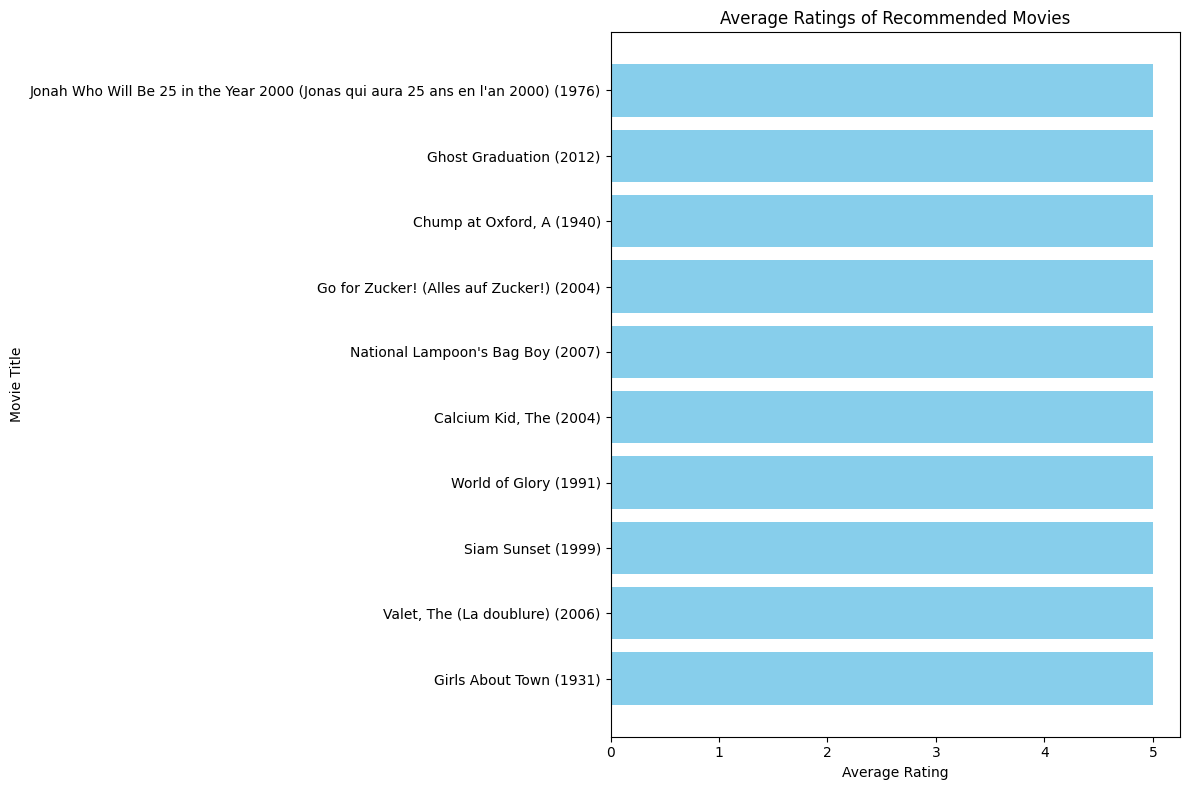

In [40]:
if not recommended_movies_df.empty:
    plt.figure(figsize=(12, 8)) # Adjusted figure size for better readability of horizontal bars
    plt.barh(recommended_movies_df['title'], recommended_movies_df['avg_rating'], color='skyblue') # Use barh for horizontal bars
    plt.xlabel("Average Rating") # Swap labels
    plt.ylabel("Movie Title") # Swap labels
    plt.title("Average Ratings of Recommended Movies")
    plt.tight_layout()
    plt.show()
else:
    print("No Recommended movies to plot.")